# Time series

## Introduction
Let as assume that at each time step $t$ we observe a vector $\mathbf{x}(t)$ with $p$ variables

\begin{equation}
    \mathbf{x}(t) = [\mathbf{x}_1(t), \mathbf{x}_2(t), \ldots, \mathbf{x}_p(t)]^\top
\end{equation}

Then, we use the following structural causal model, which considers both the instantaneous ($\tau = 0$) and lagged ($\tau \geq 1$) causal effects

\begin{equation} \label{eq:varlingam}
    \mathbf{x}(t) = \sum_{\tau=0}^{k}\mathbf{B}_{\tau}\mathbf{x}(t-\tau)+\mathbf{e}(t)
\end{equation}

where:
- $\mathbf{B}$ is the coefficient matrix representing the magnitudes of the contemporaneous ($\mathbf{B}_0$) and lagged ($\mathbf{B}_{\tau}$, $\tau=1, \ldots, h$) causal effects.
- $\mathbf{e}(t)$ are the non-Gaussian mutually independent (both of each other and over time) errors.

A sufficient condition for the coefficient matrices $\mathbf{B}_0$ and $\mathbf{B}_{\tau}$ to be identifiable is that the contemporaneous causal relations represented by the matrix $\mathbf{B}_0$ is acyclic and the error variables $e_i(t)$, with $i=1, \ldots, p$ and $t=1, \ldots, T$, are non-Gaussian and independent. This independence implies **no hidden common cause** between the observed variables at the same point in time or between the observed variables at different points in time.

## Estimation
One possible estimation method is to combine a traditional least-squares estimation of an autoregressive (AR) model with the LiNGAM estimation. The key intuition is that the model shown in the introduction is essentially **a LiNGAM model for the residuals of the predictions made by a traditional AR model** that only considers the lagged effects and not the contemporaneous ones (where $\tau >0$). The estimation method is based on three steps:

1. Obtain a least-squares estimate $\widehat{\mathbf{M}}_{\tau}$ of the AR model given by
    \begin{equation}
        \mathbf{x}(t) = \sum_{\tau=1}^{k}\mathbf{M}_{\tau}\mathbf{x}(t-\tau)+\mathbf{n}(t)
    \end{equation}
    $\widehat{\mathbf{M}}_{\tau}$ can be thought of as a matrix of the preliminary guesses for the lagged effects.
2. Compute the residuals of the AR model, which are an estimate of the true errors $\mathbf{n}(t)$
    \begin{equation}
        \widehat{\mathbf{n}}(t) = \mathbf{x}(t) - \sum_{\tau=1}^{k}\widehat{\mathbf{M}}_{\tau}\mathbf{x}(t-\tau)
    \end{equation}
    These residuals are the differences between the actual observed data and the predictions from the AR model. They should contain the influences not captured by the past values (potentially the instantaneous effects we are interested in).
3. Perform a LiNGAM analysis on the residuals, which returns an **estimate of the coefficient matrix for the instantaneous causal effects** $\mathbf{B}_0$
    \begin{equation}
        \widehat{\mathbf{n}}(t) = \mathbf{B}_0 \widehat{\mathbf{n}}(t) + \mathbf{e}(t)
    \end{equation}
    The idea is that if there are instantaneous effects, they would show up in the residuals of the AR model, because the AR model did not account for them.
4. Once $\mathbf{B}_0$ has been estimated, the next step is to disentangle the lagged causal effects from the total observed effects captured in the AR model. So, we compute the **estimates of the coefficient matrices for the lagged causal effects**, $\mathbf{B}_{\tau}$ for $\tau >0$
    \begin{equation}
        \widehat{\mathbf{B}_{\tau}} = (\mathbf{I} - \widehat{\mathbf{B}}_0) \widehat{\mathbf{M}}_{\tau}
    \end{equation}Here, we refine the estimates for $\mathbf{B}_{\tau}$. We do this by adjusting your initial estimates $\widehat{\mathbf{M}}_{\tau}$ to account for the instantaneous effects $\mathbf{B}_0$ that we have just uncovered. Mathematically, this adjustment is done by multiplying $\widehat{\mathbf{M}}_{\tau}$ by $\mathbf{I} - \widehat{\mathbf{B}}_0$. This operation essentially removes the part of the lagged effects that was actually due to instantaneous effects, giving you a purer estimate of the true lagged causal influences.

In [1]:
import numpy as np
import pandas as pd
import graphviz
import lingam
from lingam.utils import make_dot, print_causal_directions, print_dagc
import warnings
warnings.filterwarnings('ignore', category=UserWarning)
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
B0 = [[0.0, 0.0, 0.0],
      [2.0, 0.0, 0.0],
      [-1.0, 0.5,0.0]]

B1 = [[0.7, 0.0, 0.0],
      [0.2, -0.6, 0.0],
      [0.1, 0.0,0.1]]

causal_order = [0, 1, 2]

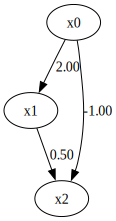

In [3]:
# Contemporaneous effects
make_dot(B0)

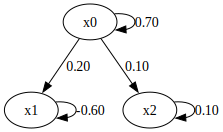

In [4]:
# Lagged effects
make_dot(B1)

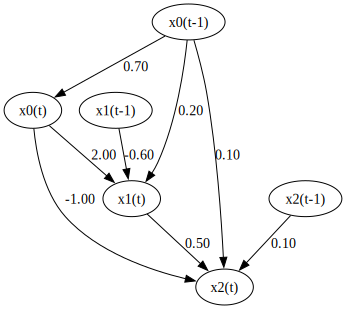

In [5]:
# Combined causal graph: contemporaneous + lagged effects
labels = ['x0(t)', 'x1(t)', 'x2(t)', 'x0(t-1)', 'x1(t-1)', 'x2(t-1)']
make_dot(np.hstack((B0, B1)), ignore_shape=True, lower_limit=0.05, labels=labels)

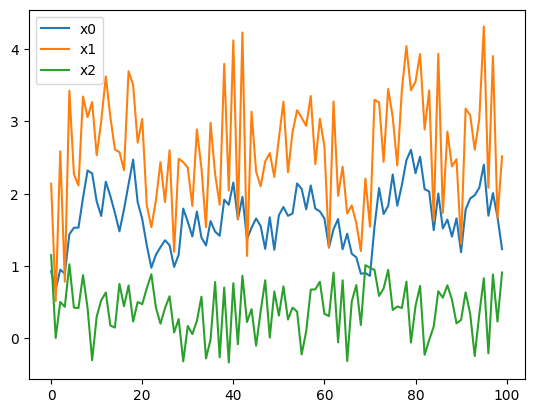

In [6]:
# Generating data according to this causal graph
B0 = np.array(B0)
B1 = np.array(B1)

# Sample size
n_features = len(causal_order)
sample_size = 100

# Initialize the data matrix with zeros (considering t and t-1)
data = np.zeros((sample_size + 1, n_features))  # +1 to accommodate initial values at t=-1

# Add non-Gaussian noise for each variable and each time point
# The choice of non-Gaussian distributions is arbitrary and can be adjusted
for i in range(n_features):
    data[:, i] += np.random.uniform(size=sample_size + 1)

# Generate data according to VARLiNGAM model
for t in range(1, sample_size + 1):
    for var in causal_order:
        data[t, var] += np.dot(B0[var, :], data[t, :]) + np.dot(B1[var, :], data[t-1, :])

# Drop the initial row used for t=-1 values
data = data[1:, :]

# Convert to DataFrame for easier handling
X = pd.DataFrame(data, columns=[f"x{i}" for i in range(n_features)])

# Plotting
for i in range(X.shape[1]):
    plt.plot(X.index, X.iloc[:, i], label=f'x{i}')
plt.legend()

### Fitting a VAR model and applying LiNGAM on the residuals to estimate $B_0$

In [7]:
from statsmodels.tsa.vector_ar.var_model import VAR

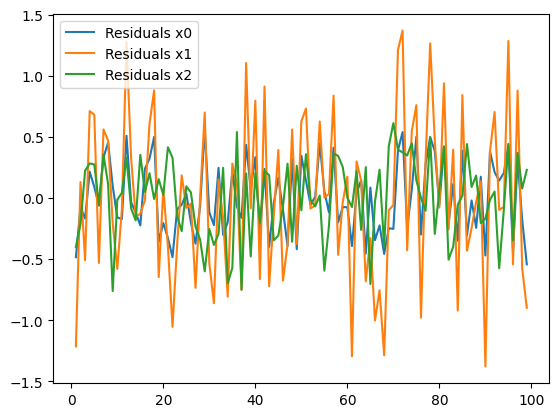

In [8]:
model = VAR(X)
results = model.fit(1)  # Fit VAR(1)
residuals = results.resid

# Plot residuals
for i in range(residuals.shape[1]):
    plt.plot(residuals.index, residuals.iloc[:, i], label=f'Residuals x{i}')
plt.legend()

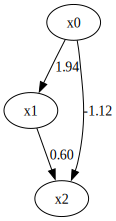

In [9]:
# Apply LiNGAM
direct_model = lingam.DirectLiNGAM()
direct_model.fit(residuals)
make_dot(direct_model.adjacency_matrix_)

### VARLiNGAM to estimate $B_1$

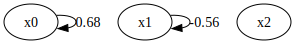

In [10]:
model = lingam.VARLiNGAM(lags=1)
model.fit(X)
make_dot(model.adjacency_matrices_[1]) # B1

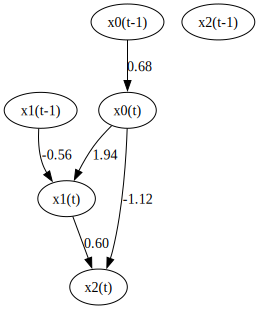

In [11]:
# Combined estimated graph
labels = ['x0(t)', 'x1(t)', 'x2(t)', 'x0(t-1)', 'x1(t-1)', 'x2(t-1)']
make_dot(np.hstack([direct_model.adjacency_matrix_, model.adjacency_matrices_[1]]), ignore_shape=True, lower_limit=0.05, labels=labels)